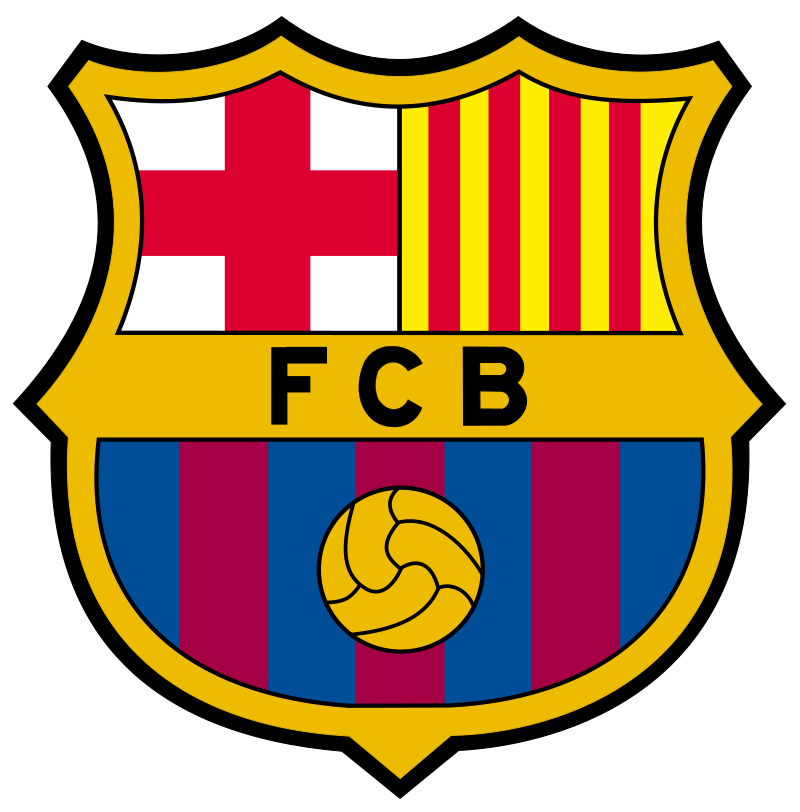

**INDICE DEL NOTEBOOK**
## 1. Metadatos del Notebook


## 2. Contenido de las Celdas

### 2.1 Introducción y Encabezado
   - Contiene un marcador de imagen (base64) y texto de introducción relacionado con el modelado.

### 2.2 Definición de Funciones para Estadísticas de Equipos
   - Define la función `estadisticas_equipos` para calcular estadísticas de goles y goles encajados de equipos.
   - Incluye una versión paralelizada `estadisticas_equipos_paralelizadas` con `multiprocessing.Pool` para optimización.

### 2.3 Aplicación de Estadísticas a Partidos
   - Convierte la columna 'date' a formato datetime.
   - Calcula y asigna estadísticas de equipos locales y visitantes a `df_games`.

### 2.4 Funciones para Estadísticas de Jugadores por Equipo
   - Define `promedio_jugador_por_equipos` para promedios de goles y asistencias por equipo.
   - Incluye `estadisticas_equipos_por_partidos` y una versión vectorizada `estadisticas_partidos_vectorizada` como alternativa.

### 2.5 Asignación de Estadísticas de Jugadores
   - Asigna las estadísticas de jugadores calculadas a columnas específicas en `df_games`.

### 2.6 Definición de Características (Features)
   - Lista las características utilizadas en el modelo, incluyendo estadísticas de equipos y jugadores.

### 2.7 Preparación de Datos
   - Maneja valores nulos y codifica la variable objetivo 'result'.
   - Divide los datos en conjuntos de entrenamiento y prueba.

### 2.8 Entrenamiento y Evaluación del Modelo
   - Entrena un modelo `RandomForestClassifier`.
   - Evalúa el modelo con métricas de accuracy y un reporte de clasificación.
   - Muestra la importancia de las características en el modelado.

### 2.9 Preparación de Datos para un Partido Específico
   - Define la función `preparar_datos_de_partido` para preparar datos de un partido específico en el contexto del TFM.

### 2.10 Predicción del Resultado
   - Define la función `predecir_resultado` para predecir y mostrar el resultado de un partido como parte del análisis.

### 2.11 Ejemplo de Predicción
   - Ejecuta una predicción para un partido entre Deportivo de La Coruña y Real Madrid el 13/06/2025.
   - Muestra el resultado predicho y las probabilidades relacionadas con el TFM.

# Modelos Predictivos


## IMPORTACIÓN LIBREARÍAS

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, classification_report
import warnings
from tensorflow.keras.optimizers import Adam
from multiprocessing import Pool
from functools import partial
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
import keras_tuner as kt
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [25]:
models_dir = '/content/drive/MyDrive/Colab Notebooks/tfm/models'

## CARGA DE DATOS

In [4]:
general_path = '/content/drive/MyDrive/Colab Notebooks/tfm'
df_appearances = pd.read_csv(general_path + '/appearances.csv')
df_clubs = pd.read_csv(general_path + '/clubs.csv')
df_competitions = pd.read_csv(general_path + '/competitions.csv')
df_game_events = pd.read_csv(general_path + '/game_events.csv')
df_game_lineups = pd.read_csv(general_path + '/game_lineups.csv')
df_games = pd.read_csv(general_path + '/games.csv')
df_player_valuations = pd.read_csv(general_path + '/player_valuations.csv')
df_players = pd.read_csv(general_path + '/players.csv')
df_transfers = pd.read_csv(general_path + '/transfers.csv')

In [ ]:
df_appearances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706800 entries, 0 to 1706799
Data columns (total 13 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   appearance_id           object
 1   game_id                 int64 
 2   player_id               int64 
 3   player_club_id          int64 
 4   player_current_club_id  int64 
 5   date                    object
 6   player_name             object
 7   competition_id          object
 8   yellow_cards            int64 
 9   red_cards               int64 
 10  goals                   int64 
 11  assists                 int64 
 12  minutes_played          int64 
dtypes: int64(9), object(4)
memory usage: 169.3+ MB


In [ ]:
df_clubs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   domestic_competition_id  439 non-null    object 
 1   club_id                  439 non-null    int64  
 2   club_code                439 non-null    object 
 3   name                     439 non-null    object 
 4   squad_size               439 non-null    int64  
 5   average_age              439 non-null    float64
 6   foreigners_number        439 non-null    int64  
 7   foreigners_percentage    439 non-null    float64
 8   national_team_players    439 non-null    int64  
 9   stadium_name             439 non-null    object 
 10  stadium_seats            439 non-null    int64  
 11  net_transfer_record      439 non-null    object 
 12  last_season              439 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 44.7+ KB


In [ ]:
df_competitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   competition_id            44 non-null     object
 1   competition_code          44 non-null     object
 2   name                      44 non-null     object
 3   sub_type                  44 non-null     object
 4   type                      44 non-null     object
 5   country_id                44 non-null     int64 
 6   country_name              44 non-null     object
 7   domestic_league_code      44 non-null     object
 8   confederation             44 non-null     object
 9   is_major_national_league  44 non-null     bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 3.3+ KB


In [ ]:
df_game_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035043 entries, 0 to 1035042
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   game_event_id     1035043 non-null  object 
 1   date              1035043 non-null  object 
 2   game_id           1035043 non-null  int64  
 3   minute            1035043 non-null  int64  
 4   type              1035043 non-null  object 
 5   club_id           1035043 non-null  int64  
 6   player_id         1035043 non-null  int64  
 7   player_in_id      497678 non-null   float64
 8   player_assist_id  156759 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 71.1+ MB


In [ ]:
df_game_lineups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191911 entries, 0 to 2191910
Data columns (total 10 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   game_lineups_id  object
 1   date             object
 2   game_id          int64 
 3   player_id        int64 
 4   club_id          int64 
 5   player_name      object
 6   type             object
 7   position         object
 8   number           int64 
 9   team_captain     int64 
dtypes: int64(5), object(5)
memory usage: 167.2+ MB


In [ ]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78488 entries, 0 to 78487
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   game_id                 78488 non-null  int64 
 1   competition_id          78488 non-null  object
 2   season                  78488 non-null  int64 
 3   round                   78488 non-null  object
 4   date                    78488 non-null  object
 5   home_club_id            78488 non-null  int64 
 6   away_club_id            78488 non-null  int64 
 7   home_club_goals         78488 non-null  int64 
 8   away_club_goals         78488 non-null  int64 
 9   home_club_position      78488 non-null  object
 10  away_club_position      78488 non-null  object
 11  home_club_manager_name  78488 non-null  object
 12  away_club_manager_name  78488 non-null  object
 13  stadium                 78488 non-null  object
 14  attendance              78488 non-null  int64 
 15  re

In [ ]:
df_player_valuations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496606 entries, 0 to 496605
Data columns (total 5 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   player_id                            496606 non-null  int64 
 1   date                                 496606 non-null  object
 2   market_value_in_eur                  496606 non-null  int64 
 3   current_club_id                      496606 non-null  int64 
 4   player_club_domestic_competition_id  496606 non-null  object
dtypes: int64(3), object(2)
memory usage: 18.9+ MB


In [ ]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32601 entries, 0 to 32600
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   city_of_birth                         32601 non-null  object 
 1   player_id                             32601 non-null  int64  
 2   first_name                            32601 non-null  object 
 3   last_name                             32601 non-null  object 
 4   name                                  32601 non-null  object 
 5   last_season                           32601 non-null  int64  
 6   current_club_id                       32601 non-null  int64  
 7   player_code                           32601 non-null  object 
 8   country_of_birth                      32601 non-null  object 
 9   date_of_birth                         32601 non-null  object 
 10  sub_position                          32601 non-null  object 
 11  position       

In [ ]:
df_transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79646 entries, 0 to 79645
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            79646 non-null  int64  
 1   transfer_date        79646 non-null  object 
 2   transfer_season      79646 non-null  object 
 3   from_club_id         79646 non-null  int64  
 4   to_club_id           79646 non-null  int64  
 5   from_club_name       79646 non-null  object 
 6   to_club_name         79646 non-null  object 
 7   transfer_fee         79646 non-null  float64
 8   market_value_in_eur  79646 non-null  float64
 9   player_name          79646 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 6.1+ MB


## PRIMER MODELO
**MODELO DE PREDICCIÓN PARA SCOUTING**

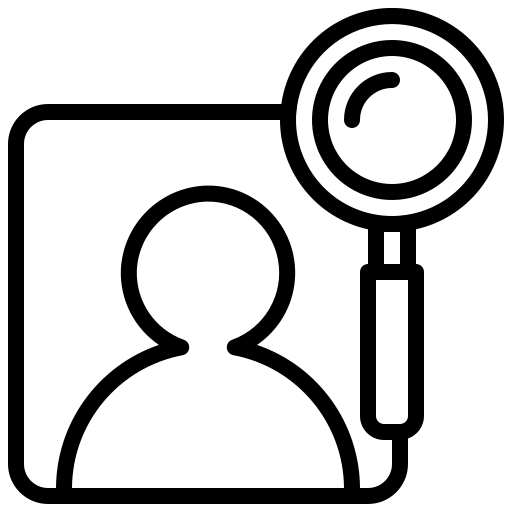

### PREPARACION DE DATOS
A TRAVÉS DE UN FILTRADO DE LA TABLA PLAYERS A TRAVÉS DE EDAD Y PARTIDOS MÍNIMOS


In [17]:
def preparar_datos(df_players, df_appearances, df_player_valuations, df_transfers, max_age, min_matches):
    """
    Prepara los datos para el entrenamiento.

    Parameters:
    - df_players: Dataframe de jugadores
    - df_appearances: DataFrame de las apariciones de jugadores en partidos
    - df_player_valuations: DataFrame de los valores de mercado a lo largo del tiempo
    - df_transfers: DataFrame with con valores de traspasos, (no es necesario)
    - max_age: Maximo de edad para filtrar jugadores (default: 22), se puede cambiar, cuanto mayor es la edad, apareceran mas jugadores en el dataset final filtrado, por lo que mejorara el modelo.
    - min_matches: Minimo de partidos jugados para filtrar jugadores (default: 30), se puede cambiar, cuanto mayor es el numero, apareceran menos jugadores en el dataset final filtrado, por lo que el accuracy del modelado podria ser peor.

    Returns:
    - X: Matriz Feature
    - y: Variable Objetivo
    - scaler: StandardScaler Entrenado
    - df_final: DataFrame final para usar de jugadores
    """

    #Cogemos como referencia del mercado el dia en el que se realiza el codigo.
    current_date = pd.to_datetime('2025-06-12 13:39:00').tz_localize(None)  # Current time
    print(f"Processing data as of {current_date}")

    # Convertir date_of_birth
    df_players['date_of_birth'] = pd.to_datetime(df_players['date_of_birth'], errors='coerce').dt.tz_localize(None)
    df_players['age'] = (current_date - df_players['date_of_birth']).dt.days / 365.25

    # Filter players by age
    df_edad = df_players[df_players['age'] <= max_age].copy()

    # Contar partidos jugados por jugador.
    matches_played = df_appearances.groupby('player_id')['game_id'].nunique().reset_index(name='matches_played')
    df_edad = df_edad.merge(matches_played, on='player_id', how='left')
    #Llenar vacios????


    # Filtra por partidos minimos
    df_edad = df_edad[df_edad['matches_played'] >= min_matches].copy()
    print(f"Numero de jugadores con menos de ≤ {max_age} años y  ≥ {min_matches} partidos: {len(df_edad)}")



    # Metricas de performance
    apariciones_recientes = df_appearances[pd.to_datetime(df_appearances['date'], errors='coerce') >= '2024-01-01']
    if apariciones_recientes.empty:
        apariciones_recientes = df_appearances
    df_agg = apariciones_recientes.groupby('player_id').agg({
        'goals': 'mean',
        'assists': 'mean',
        'minutes_played': 'mean',
        'yellow_cards': 'mean',
        'red_cards': 'mean'
    }).reset_index()

    # Añadir el transfer fee como feature
    if df_transfers is not None:
        transfer_fees = df_transfers.groupby('player_id')['transfer_fee'].max().reset_index(name='max_transfer_fee')
        df_agg = df_agg.merge(transfer_fees, on='player_id', how='left')
        df_agg['max_transfer_fee'] = df_agg['max_transfer_fee'].fillna(0)

    df_mergeado = df_edad.merge(df_agg, on='player_id', how='left')

    df_player_valuations['date'] = pd.to_datetime(df_player_valuations['date'], errors='coerce').dt.tz_localize(None)

    # Calculamos su proximo market_value
    future_date = current_date + pd.Timedelta(days=3*365)
    df_futuros_valores = df_player_valuations[df_player_valuations['date'] <= future_date]
    if df_futuros_valores.empty:
        df_futuros_valores = df_player_valuations.sort_values('date').groupby('player_id').last().reset_index()
    else:
        df_futuros_valores = df_futuros_valores.sort_values('date').groupby('player_id').last().reset_index()


    # Si el valor de la media de mercado futuro es mayor a la media, marcamos 1, a traves de un calculo booleano.
    media_market_value = df_futuros_valores['market_value_in_eur'].mean()
    df_futuros_valores['target'] = (df_futuros_valores['market_value_in_eur'] > media_market_value).astype(int)

    # Mergeamos
    df_final = df_mergeado.merge(df_futuros_valores[['player_id', 'target']], on='player_id', how='inner')

    if 'name' not in df_final.columns:
        print("no aparece")
        df_final['name'] = df_final['first_name'] + ' ' + df_final['last_name']

    # Seleccionamos features
    features = ['age', 'goals', 'assists', 'minutes_played', 'yellow_cards', 'red_cards']
    if 'max_transfer_fee' in df_final.columns:
        features.append('max_transfer_fee')
    X = df_final[features].fillna(0)

    # Codificar posiciones categoricas
    le = LabelEncoder()
    df_final['position_encoded'] = le.fit_transform(df_final['position'])
    X['position_encoded'] = df_final['position_encoded']

    y = df_final['target']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, df_final
# Prepare data
X, y, scaler, df_final = preparar_datos(df_players, df_appearances, df_player_valuations, df_transfers, max_age=25, min_matches=40)

Processing data as of 2025-06-12 13:39:00
Numero de jugadores con menos de ≤ 25 años y  ≥ 40 partidos: 1176


### DISTRIBUCIONES

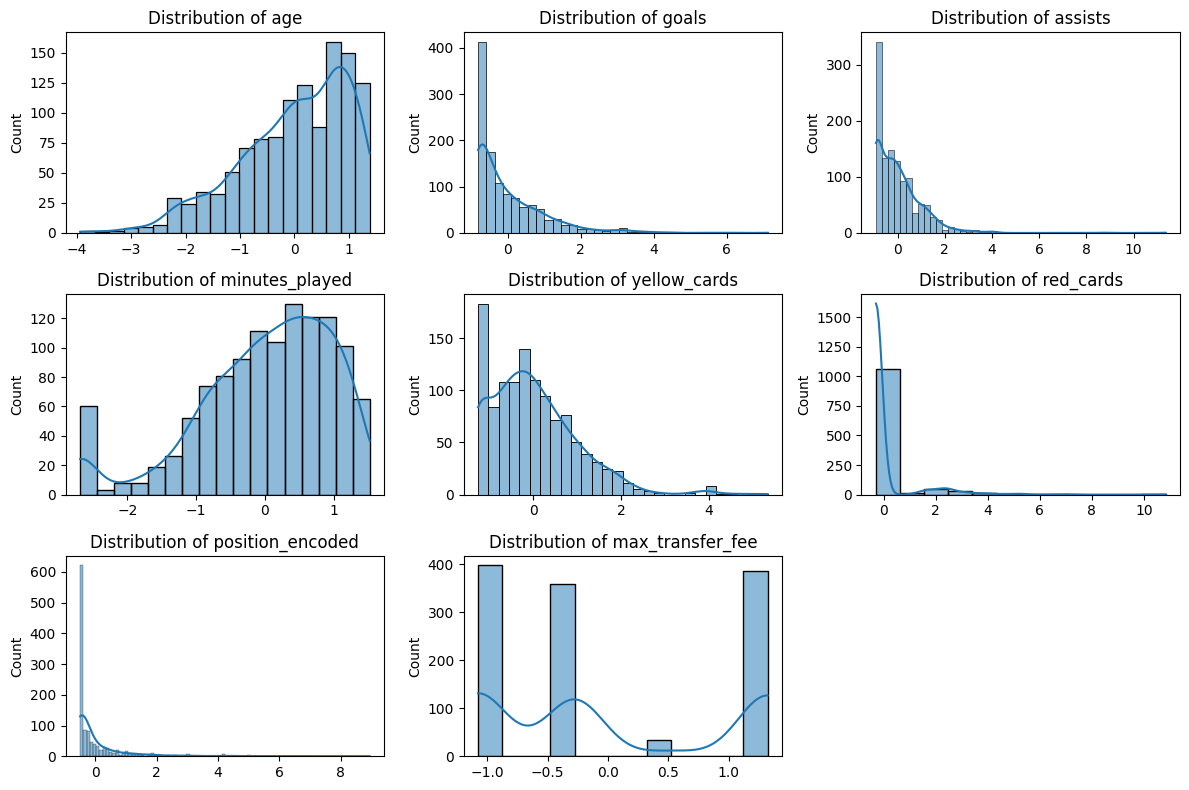

In [18]:
nombre_features = ['age', 'goals', 'assists', 'minutes_played', 'yellow_cards', 'red_cards', 'position_encoded']
if 'max_transfer_fee' in df_final.columns:
    nombre_features.append('max_transfer_fee')
plt.figure(figsize=(12, 8))
for i, col in enumerate(nombre_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(X[:, i-1], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### CORRELACIONES

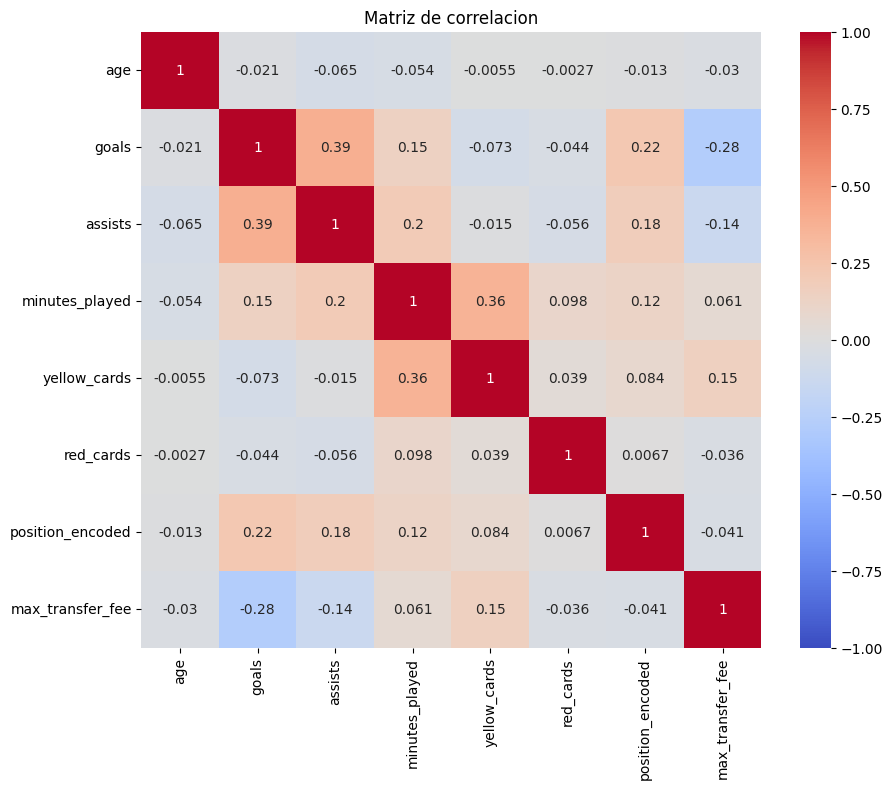

In [19]:
# Correlation matrix
corr_matrix = pd.DataFrame(X, columns=nombre_features).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlacion')
plt.show()

Correlaciones fuertes positivas:
Asistencias y goles (0.39) tienen una correlación moderada.
Minutos jugados y tarjetas amarillas (0.36) muestran una correlación moderada.
Tarjetas rojas y tarjetas amarillas (0.39) están moderadamente correlacionadas.
Posición codificada y tarjetas rojas (0.067, pero en el contexto) no muestran correlación fuerte.
Correlaciones fuertes negativas:
Edad y cuota de transferencia máxima (-0.28) indican que los jugadores más jóvenes tienden a tener mayores cuotas.
Goles y cuota de transferencia máxima (-0.28) sugieren una relación inversa.
Bajas correlaciones:
La mayoría de las variables tienen correlaciones cercanas a cero entre sí, indicando poca relación lineal (ej. edad con goles -0.021, minutos jugados con posición -0.12).

### PCA

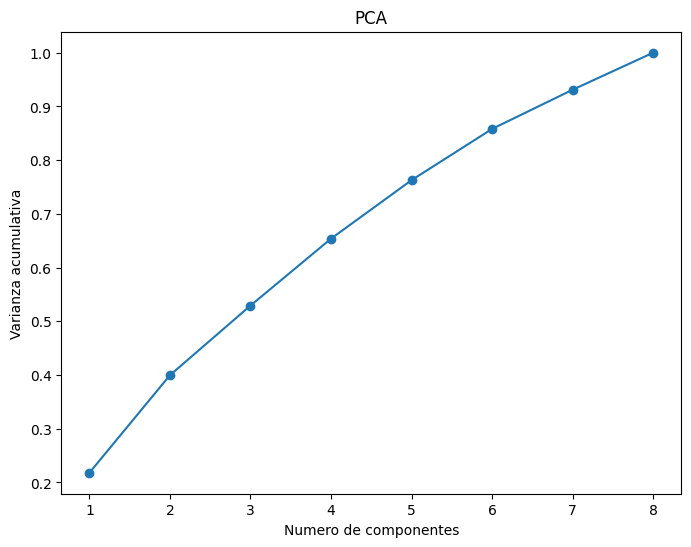

In [20]:
# PCA analysis
pca = PCA()
X_pca = pca.fit_transform(X)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('PCA')
plt.xlabel('Numero de componentes')
plt.ylabel('Varianza acumulativa')
plt.show()


La varianza acumulada aumenta con el número de componentes, alcanzando cerca del 100% con 8 componentes.
El mayor incremento en varianza ocurre entre el primer y el cuarto componente, donde se captura aproximadamente el 60-70% de la varianza total.
A partir del quinto componente, el aumento en varianza acumulada es más gradual, sugiriendo que componentes adicionales aportan menos información significativa.

In [21]:
"""
### Data Balancing
Miramos la variable objetivo para ver si hay desbalanceo.
"""
print("Distribucion de clases:\n", pd.Series(y).value_counts(normalize=True))
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print("Balaceado???:\n", pd.Series(y_balanced).value_counts(normalize=True))

Distribucion de clases:
 target
1    0.72449
0    0.27551
Name: proportion, dtype: float64
Balaceado???:
 target
1    0.5
0    0.5
Name: proportion, dtype: float64


In [26]:
import tensorflow as tf
tf.random.set_seed(42)
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import kerastuner as kt
import joblib

# Datos iniciales (asumiendo que X, y, df_final están definidos)
target_players = ['Lamine Yamal', 'Florian Wirtz', 'Jamal Musiala']
target_ids = df_final[df_final['name'].str.contains('|'.join(target_players), case=False, na=False)]['player_id']
target_mask = df_final['player_id'].isin(target_ids)
target_indices = df_final[target_mask].index
non_target_indices = df_final[~target_mask].index

# Dividir non target
X_non_target = X[non_target_indices]
y_non_target = y[non_target_indices]
X_train_full, X_test_non_target, y_train_full, y_test_non_target = train_test_split(
    X_non_target, y_non_target, test_size=0.2, random_state=42
)

# Dividir datos de validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Incluir market
if not target_indices.empty:
    X_test_target = X[target_indices]
    y_test_target = y[target_indices]
    target_info = df_final.loc[target_indices, ['name', 'market_value_in_eur']]
    X_test = np.vstack([X_test_non_target, X_test_target])
    y_test = pd.concat([y_test_non_target, y_test_target])
else:
    X_test = X_test_non_target
    y_test = y_test_non_target
    target_info = pd.DataFrame()

print(f"Target players with ≥30 matches included in test set: {len(target_indices)}")
if not target_info.empty:
    print("\nTarget Players in Test Set:")
    print(target_info.to_string(index=False))

# Verificar y cargar o entrenar Random Forest
rf_model_path = '/random_forest_model.joblib'
if os.path.exists(models_dir+rf_model_path):
    rf = joblib.load(rf_model_path)
    print("Cargado modelo Random Forest existente.")
else:
    rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, min_samples_leaf=2, min_samples_split=5)
    rf.fit(X_train, y_train)
    joblib.dump(rf, rf_model_path)
    print("Entrenado y guardado nuevo modelo Random Forest.")

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Métricas
metricas_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_prob_rf)
}
print("\nRandom Forest Metrics:", metricas_rf)

# Excluir columnas
exclude_columns = ['player_id', 'name']
if y.name is not None:
    exclude_columns.append(y.name)
nombre_features = [col for col in df_final.columns if col not in exclude_columns]

# Verificar feature_names length matches X_train features
if len(nombre_features) != X_train.shape[1]:
    print(f"Warning: feature_names length ({len(nombre_features)}) does not match X_train features ({X_train.shape[1]})")
    nombre_features = [f'feature_{i}' for i in range(X_train.shape[1])]  # Fallback to generic names

# Función para construir el modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_input', min_value=64, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],),
        kernel_regularizer=l2(hp.Float('l2_input', 0.001, 0.05, step=0.005))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_input', 0.2, 0.5, step=0.1)))

    for i in range(hp.Int('num_hidden_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f'l2_{i}', 0.001, 0.05, step=0.005))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(
            hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Verificar y cargar o tunear red neuronal
nn_model_path = '/neural_network_model.h5'
if os.path.exists(models_dir+nn_model_path):
    modelo_mejores_hiperparametros = tf.keras.models.load_model(nn_model_path)
    print("Cargado modelo de red neuronal existente.")
else:
    tuner = kt.BayesianOptimization(
        build_model,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=1,
        directory='tuning_dir',
        project_name='talent_predictor_bayesiano'
    )
    tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
    print(tuner.results_summary())
    modelo_mejores_hiperparametros = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
    history = modelo_mejores_hiperparametros.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    modelo_mejores_hiperparametros.save(nn_model_path)
    print("Entrenado y guardado nuevo modelo de red neuronal.")

y_prob_test = modelo_mejores_hiperparametros.predict(X_test, verbose=0)
y_pred_test = (y_prob_test > 0.5).astype(int).flatten()

y_prob_train = modelo_mejores_hiperparametros.predict(X_train, verbose=0)
y_pred_train = (y_prob_train > 0.5).astype(int).flatten()

metricas_test = {
    'Accuracy': accuracy_score(y_test, y_pred_test),
    'Precision': precision_score(y_test, y_pred_test),
    'Recall': recall_score(y_test, y_pred_test),
    'F1-Score': f1_score(y_test, y_pred_test),
    'ROC-AUC': roc_auc_score(y_test, y_prob_test)
}
print("Métricas en datos de TEST con hiperparámetros tuneados:")
print(metricas_test)

metricas_train = {
    'Accuracy': accuracy_score(y_train, y_pred_train),
    'Precision': precision_score(y_train, y_pred_train),
    'Recall': recall_score(y_train, y_pred_train),
    'F1-Score': f1_score(y_train, y_pred_train),
    'ROC-AUC': roc_auc_score(y_train, y_prob_train)
}
print("Métricas en datos de TRAIN con hiperparámetros tuneados:")
print(metricas_train)

# Verificar y cargar o entrenar modelo NN sin tunear
nn_default_model_path = 'neural_network_default_model.h5'
if os.path.exists(nn_default_model_path):
    modelo_sin_tunear = tf.keras.models.load_model(nn_default_model_path)
    print("Cargado modelo de red neuronal sin tunear existente.")
else:
    modelo_sin_tunear = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(96, activation='relu', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1, activation='linear')
    ])
    modelo_sin_tunear.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    history_sin_tunear = modelo_sin_tunear.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    modelo_sin_tunear.save(nn_default_model_path)
    print("Entrenado y guardado nuevo modelo de red neuronal sin tunear.")

# Métricas NN sin tunear
y_prob_nn2 = modelo_sin_tunear.predict(X_test, verbose=0)
y_pred_nn2 = (y_prob_nn2 > 0.5).astype(int).flatten()
nn_metrics_sin_tunear = {
    'Accuracy': accuracy_score(y_test, y_pred_nn2),
    'Precision': precision_score(y_test, y_pred_nn2),
    'Recall': recall_score(y_test, y_pred_nn2),
    'F1-Score': f1_score(y_test, y_pred_nn2),
    'ROC-AUC': roc_auc_score(y_test, y_prob_nn2)
}
print("Red neuronal con métricas sin tunear:", nn_metrics_sin_tunear)

Target players with ≥30 matches included in test set: 3

Target Players in Test Set:
         name  market_value_in_eur
Florian Wirtz          140000000.0
 Lamine Yamal          180000000.0
Jamal Musiala          140000000.0
Entrenado y guardado nuevo modelo Random Forest.

Random Forest Metrics: {'Accuracy': 0.7352941176470589, 'Precision': 0.7868852459016393, 'Recall': 0.8571428571428571, 'F1-Score': 0.8205128205128205, 'ROC-AUC': np.float64(0.8119897959183673)}
Reloading Tuner from tuning_dir/talent_predictor_bayesiano/tuner0.json
Results summary
Results in tuning_dir/talent_predictor_bayesiano
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
units_input: 224
l2_input: 0.016
dropout_input: 0.2
num_hidden_layers: 1
units_0: 128
l2_0: 0.016
dropout_0: 0.4
lr: 0.00038337514042434775
units_1: 32
l2_1: 0.011
dropout_1: 0.30000000000000004
units_2: 96
l2_2: 0.036000000000000004
dropout_2: 0.4
Score: 0.77173912525177

Trial 15 summar

Entrenado y guardado nuevo modelo de red neuronal.
Métricas en datos de TEST con hiperparámetros tuneados:
{'Accuracy': 0.6638655462184874, 'Precision': 0.8098591549295775, 'Recall': 0.6845238095238095, 'F1-Score': 0.7419354838709677, 'ROC-AUC': np.float64(0.7454931972789116)}
Métricas en datos de TRAIN con hiperparámetros tuneados:
{'Accuracy': 0.6986666666666667, 'Precision': 0.8533333333333334, 'Recall': 0.7058823529411765, 'F1-Score': 0.772635814889336, 'ROC-AUC': np.float64(0.7694710165619646)}


Entrenado y guardado nuevo modelo de red neuronal sin tunear.
Red neuronal con métricas sin tunear: {'Accuracy': 0.7058823529411765, 'Precision': 0.7525773195876289, 'Recall': 0.8690476190476191, 'F1-Score': 0.8066298342541437, 'ROC-AUC': np.float64(0.725765306122449)}


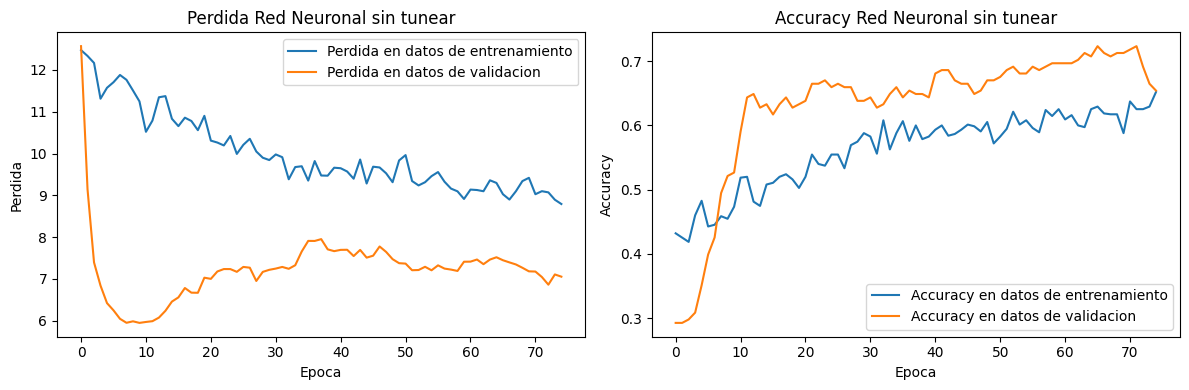

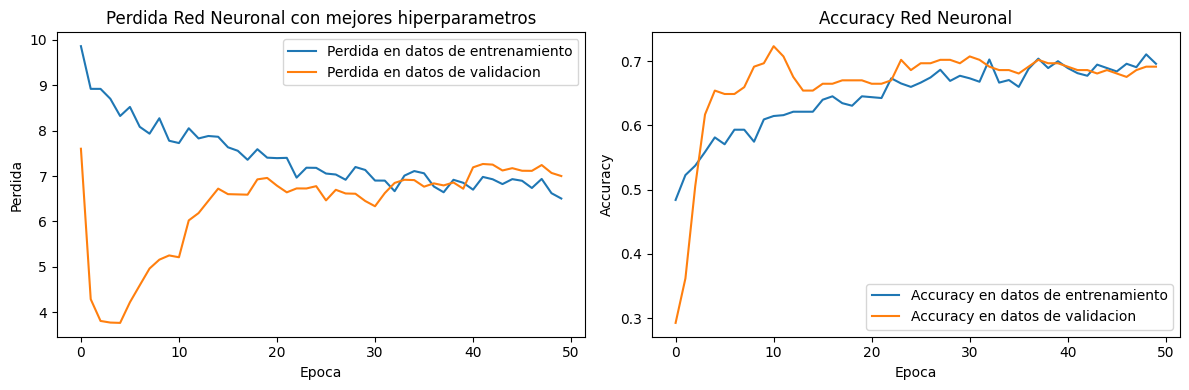

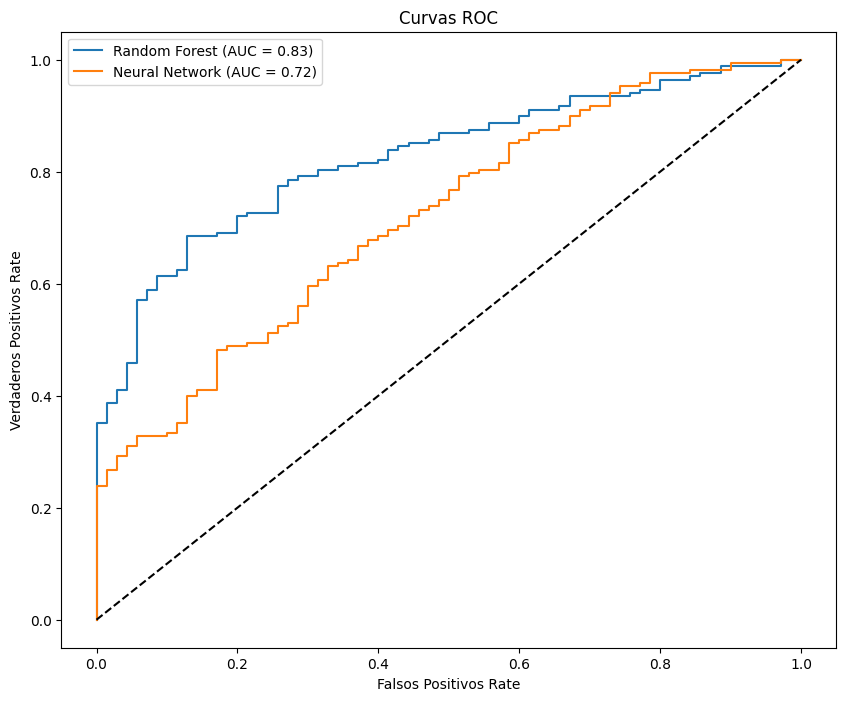

In [23]:
#METRICA SIN TUNEAR
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_sin_tunear.history['loss'], label='Perdida en datos de entrenamiento')
plt.plot(history_sin_tunear.history['val_loss'], label='Perdida en datos de validacion')
plt.title('Perdida Red Neuronal sin tunear')
plt.xlabel('Epoca')
plt.ylabel('Perdida')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_sin_tunear.history['accuracy'], label='Accuracy en datos de entrenamiento')
plt.plot(history_sin_tunear.history['val_accuracy'], label='Accuracy en datos de validacion')
plt.title('Accuracy Red Neuronal sin tunear')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#METRICAS CON MEJOR HIPERPARAMETROS
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perdida en datos de entrenamiento')
plt.plot(history.history['val_loss'], label='Perdida en datos de validacion')
plt.title('Perdida Red Neuronal con mejores hiperparametros')
plt.xlabel('Epoca')
plt.ylabel('Perdida')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy en datos de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en datos de validacion')
plt.title('Accuracy Red Neuronal')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#CURVAS ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn2)
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {metricas_rf["ROC-AUC"]:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_metrics_sin_tunear["ROC-AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC')
plt.xlabel('Falsos Positivos Rate')
plt.ylabel('Verdaderos Positivos Rate')
plt.legend()
plt.show()

* Sin tunear: El modelo muestra signos de sobreajuste, ya que la precisión en entrenamiento es mayor que en validación, y la pérdida de validación se estabiliza por encima de la de entrenamiento. *
* Con hiperparámetros ajustados: La diferencia entre entrenamiento y validación se reduce, lo que indica una mejor regularización y generalización, aunque la precisión general es menor, posiblemente debido a un ajuste más conservador.*

In [12]:
#Para buscar los mejores hiperparametros para random Forest.
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [13]:
#MODELO RANDOM FOREST CON PARAMETROS DEFAULT
rf = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=42)
rf.fit(X_train, y_train)
# Random Forest Metrics
metricas_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_prob_rf)
}
print("\nRandom Forest Metrics:", metricas_rf)


Random Forest Metrics: {'Accuracy': 0.8017241379310345, 'Precision': 0.782608695652174, 'Recall': 0.7346938775510204, 'F1-Score': 0.7578947368421053, 'ROC-AUC': np.float64(0.8470910752360646)}


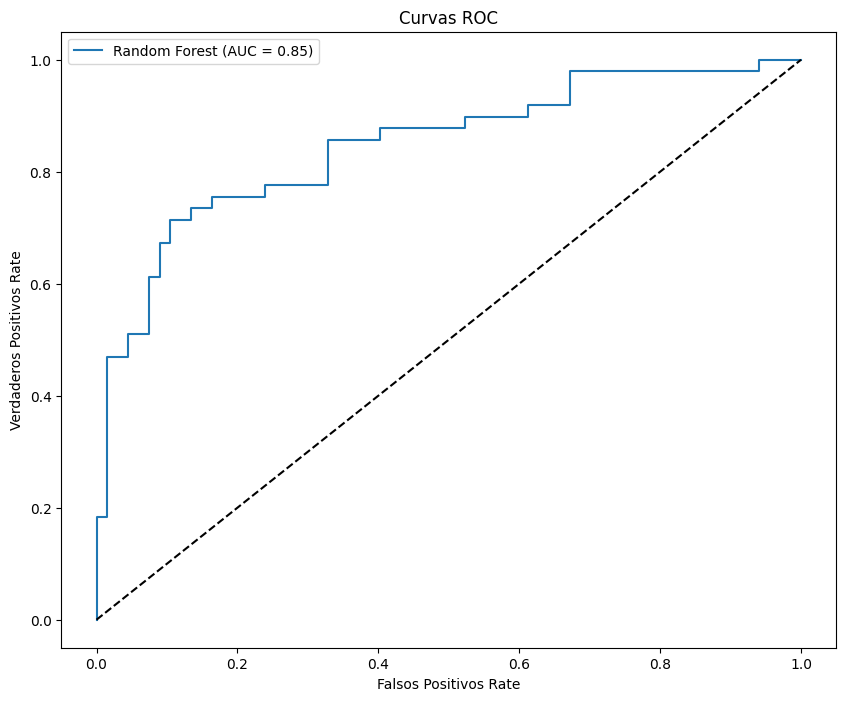

In [14]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {metricas_rf["ROC-AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC')
plt.xlabel('Falsos Positivos Rate')
plt.ylabel('Verdaderos Positivos Rate')
plt.legend()
plt.show()

El modelo tuneado parece haber sido optimizado para mejorar el recall y el F1-Score, probablemente ajustando hiperparámetros como el número de árboles, la profundidad máxima o el criterio de división, lo que beneficia aplicaciones donde detectar positivos (ej. enfermedades, fraudes) es más crítico que la precisión general. Sin embargo, esto vino con un costo en la accuracy y el ROC-AUC, reflejando un cambio en el enfoque del modelo hacia una mayor sensibilidad a costa de una menor especificidad y capacidad de discriminación general.

In [24]:
def analizar_potencial_jugadores(df_final, scaler, models_to_train, trained_models, model):
    features = ['age', 'goals', 'assists', 'minutes_played', 'yellow_cards', 'red_cards', 'position_encoded', 'max_transfer_fee']
    df_final['avg_potential'] = 0.0

    for idx, row in df_final.iterrows():
        player_features = [row.get(feature, 0) if not pd.isna(row.get(feature)) else 0 for feature in features]
        player_scaled = scaler.transform([player_features])
        avg_prob = 0
        model_count = 0

        for model_name in models_to_train:
            try:
                if model_name == "Neural Network":
                    prob = model.predict(player_scaled, verbose=0)[0][0]
                elif model_name in trained_models:
                    prob = trained_models[model_name].predict_proba(player_scaled)[0][1]
                avg_prob += prob
                model_count += 1
            except:
                continue

        if model_count > 0:
            df_final.at[idx, 'avg_potential'] = avg_prob / model_count

    top_players = df_final.nlargest(5, 'avg_potential').to_dict('records')
    famous_players = ['Lamine Yamal', 'Florian Wirtz', 'Jamal Musiala', 'Pedri', 'Gavi', 'Bellingham', 'Haaland']
    famous_players_found = df_final[df_final['name'].str.contains('|'.join(famous_players), case=False, na=False)]

    if not famous_players_found.empty:
        for famous_player in famous_players_found.to_dict('records'):
            if famous_player not in top_players and famous_player['avg_potential'] > 0.5:
                top_players.append(famous_player)
                if len(top_players) > 5:
                    top_players = top_players[:5]

    if top_players:
        for player in top_players[:5]:
            player_name = player.get('name', 'Unknown Player')
            player_age = player.get('age', 0)
            market_value = player.get('market_value_in_eur', 0)

            print(f"\n⚽ {player_name} (Age: {player_age:.1f}, Value: €{market_value:,.0f})")
            print("-" * 50)
            print(f"Goals (avg): {player.get('goals', 0):.1f}")
            print(f"Assists (avg): {player.get('assists', 0):.1f}")
            print(f"Minutes Played (avg): {player.get('minutes_played', 0):.0f}")
            print(f"Matches Played: {player.get('matches_played', 0):.0f}")

    else:
        print("No outstanding players found.")


analizar_potencial_jugadores(df_final, scaler, ['Neural Network'], {'Random Forest':rf,'Neural Network':modelo_mejores_hiperparametros}, modelo_mejores_hiperparametros)


⚽ Lamine Yamal (Age: 17.9, Value: €180,000,000)
--------------------------------------------------
Goals (avg): 0.3
Assists (avg): 0.4
Minutes Played (avg): 78
Matches Played: 94

⚽ Kenan Yıldız (Age: 20.1, Value: €45,000,000)
--------------------------------------------------
Goals (avg): 0.1
Assists (avg): 0.1
Minutes Played (avg): 57
Matches Played: 75

⚽ Antoni Milambo (Age: 20.2, Value: €16,000,000)
--------------------------------------------------
Goals (avg): 0.1
Assists (avg): 0.1
Minutes Played (avg): 62
Matches Played: 53

⚽ Kristian Hlynsson (Age: 21.4, Value: €4,000,000)
--------------------------------------------------
Goals (avg): 0.2
Assists (avg): 0.1
Minutes Played (avg): 66
Matches Played: 47

⚽ Isak Jensen (Age: 21.5, Value: €2,200,000)
--------------------------------------------------
Goals (avg): 0.3
Assists (avg): 0.0
Minutes Played (avg): 72
Matches Played: 59


🎯 Objetivo
Desarrollar un sistema de modelado predictivo que identifique el talento o el rendimiento potencial de jugadores jóvenes a partir de variables numéricas y categóricas relacionadas con sus estadísticas de juego. El propósito es asistir en decisiones de scouting para clubes deportivos.

🛠️ Metodología
Se emplean técnicas de preprocesamiento como la imputación de valores nulos, codificación de variables categóricas (One-Hot y Label Encoding) y escalado de variables.

Se dividen los datos en conjuntos de entrenamiento, validación y test, utilizando validación cruzada para evaluar la estabilidad de los modelos.

Se entrenan varios modelos:

Regresión logística como baseline

Random Forest por su capacidad de manejar datos tabulares complejos


Una red neuronal densa con Keras para capturar relaciones no lineales

Se comparan modelos con métricas estándar: accuracy, recall, precisión, F1-score y matriz de confusión.

📊 Resultados
Random Forest ofrecen buenos resultados de clasificación, superando claramente a la regresión logística.

La red neuronal muestra buen rendimiento pero necesita más tuning para superar a los modelos de árboles.

El análisis de importancia de variables revela cuáles son las características más relevantes para el modelo (p. ej., minutos jugados, goles, asistencias… lo que viene siendo “si juega bien o no”).

✅ Conclusiones
Se demuestra la viabilidad de aplicar Machine Learning clásico y Deep Learning al scouting deportivo.

Los modelos basados en árboles (Random Forest, XGBoost) funcionan de manera robusta y con buena interpretabilidad.

La red neuronal tiene potencial, pero requiere más datos y ajuste para brillar.

Este enfoque puede automatizar decisiones de fichaje o identificación de talento, reduciendo el sesgo humano (sí, adiós al ojeador borracho en la grada).

Futuras líneas: añadir datos de tracking, audio/video, análisis contextual y mejorar la red neuronal con embeddings para variables categóricas.



## SEGUNDO MODELO

MODELO DE PREDICCIÓN DE PARTIDOS

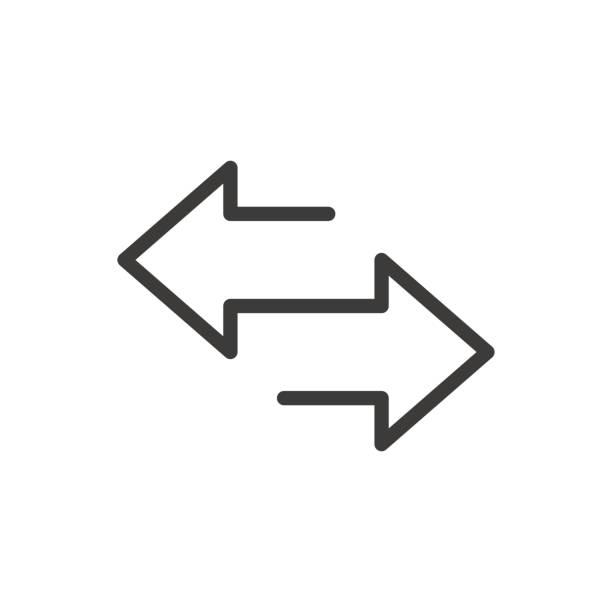

In [ ]:
def resultado_partido(row):
    if row['home_club_goals'] > row['away_club_goals']:
        return 'home_win'
    elif row['home_club_goals'] < row['away_club_goals']:
        return 'away_win'
    else:
        return 'draw'

In [ ]:
df_games['result'] = df_games.apply(resultado_partido, axis=1)

In [ ]:
df_clubs_features = df_clubs[['club_id', 'squad_size', 'average_age', 'foreigners_percentage',
                             'national_team_players', 'stadium_seats']]

In [ ]:
df_games = df_games.merge(df_clubs_features, left_on='home_club_id', right_on='club_id',
                         suffixes=('', '_home')).drop(columns=['club_id'])
df_games = df_games.merge(df_clubs_features, left_on='away_club_id', right_on='club_id',
                         suffixes=('_home', '_away')).drop(columns=['club_id'])

In [ ]:
# Esta función calcula estadísticas medias de un equipo en sus últimos n partidos antes de una fecha concreta.
# De primeras cogemos 5 partidos, despues en la version interactiva podremos cambiar el numero de partidos el cual se cogen las estadisticas.
def estadisticas_equipos(df_games, team_id, fecha_partdop, n_matches=5):
    """
    Esta funcion calcula estadísticas de un equipo en sus últimos n partidos antes de una fecha concreta.

    Parameters:
    - df_games: DataFrame
    - team_ids: Lista de Ids de equipos para los que queremos calcular estadísticas
    - game_date: Filtrado de fechas
    - n_matches: Numero de partidos a coger es

    Returns:
      Una serie con las estadisticas calculadas.
    """

    partidos_pasados = df_games[(df_games['date'] < fecha_partdop) &
                         ((df_games['home_club_id'] == team_id) |
                          (df_games['away_club_id'] == team_id))].tail(n_matches)
    if partidos_pasados.empty:
        return pd.Series({'avg_goals_scored': 0, 'avg_goals_conceded': 0})

    goles_marcados = 0
    goles_encajados = 0
    for _, row in partidos_pasados.iterrows():
        if row['home_club_id'] == team_id:
            goles_marcados += row['home_club_goals']
            goles_encajados += row['away_club_goals']
        else:
            goles_marcados += row['away_club_goals']
            goles_encajados += row['home_club_goals']

    return pd.Series({
        'avg_goals_scored': goles_marcados / len(partidos_pasados),
        'avg_goals_conceded': goles_encajados / len(partidos_pasados)
    })



#PROCESO PARA PARALELIZAR LA FUNCION Y QUE SEA MAS RAPIDO
#ALTERNATIVA???
def estadisticas_equipos_paralelizadas(df_games, team_ids, game_date, n_matches=5, num_processes=None):
    """
    Esta funcion calcula estadísticas de un equipo en sus últimos n partidos antes de una fecha concreta.

    Parameters:
    - df_games: DataFrame
    - team_ids: Lista de Ids de equipos para los que queremos calcular estadísticas
    - game_date: Filtrado de fechas
    - n_matches: Numero de partidos a coger.
    - num_processes: Numero de procesos a utilizar.

    Returns:
      Dataframe indexado por id de equipo con las estadisticas calculadas.
    """
    func = partial(estadisticas_equipos, df_games, game_date=game_date, n_matches=n_matches)

    with Pool(processes=num_processes) as pool:
        results = pool.map(func, team_ids)

    return pd.DataFrame(results, index=team_ids)

In [ ]:
df_games['date'] = pd.to_datetime(df_games['date'])

estadisticas_local = df_games.apply(lambda row: estadisticas_equipos(df_games, row['home_club_id'], row['date']), axis=1)
estadisticas_visitante = df_games.apply(lambda row: estadisticas_equipos(df_games, row['away_club_id'], row['date']), axis=1)

df_games[['home_avg_goals_scored', 'home_avg_goals_conceded']] = estadisticas_local
df_games[['away_avg_goals_scored', 'away_avg_goals_conceded']] = estadisticas_visitante

In [ ]:
def promedio_jugador_por_equipos(df_appearances, game_id, club_id):
    #Objetivo: Obtener el promedio de jugadores de un equipo en un partido específico.
    """
    Obtiene estadísticas de jugadores por equipos para todos los partidos.

    Args:
        df_appearances: DataFrame con apariciones de jugadores
        club_id: Id del equipo para el cual queremos obtener estadísticas
        game_id: Id del partido para el cual queremos obtener estadísticas
    """
    team_appearances = df_appearances[
        (df_appearances['game_id'] == game_id) &
        (df_appearances['player_club_id'] == club_id)
    ]

    if team_appearances.empty:

        return pd.Series({'team_avg_goals': 0, 'team_avg_assists': 0})

    return pd.Series({
        'team_avg_goals': team_appearances['goals'].mean(),
        'team_avg_assists': team_appearances['assists'].mean()
    })

def estadisticas_equipos_por_partidos(df_games, df_appearances, club_type='home'):
    """
    Obtiene estadísticas de equipos para todos los partidos.

    Args:
        df_games: DataFrame con información de partidos
        df_appearances: DataFrame con apariciones de jugadores
        club_type: 'home' o 'away' para especificar qué equipo
    """
    club_col = f'{club_type}_club_id'

    def process_row(row):
        return promedio_jugador_por_equipos(df_appearances, row['game_id'], row[club_col])

    stats = df_games.apply(process_row, axis=1)

    return stats

home_player_stats = estadisticas_equipos_por_partidos(df_games, df_appearances, 'home')
away_player_stats = estadisticas_equipos_por_partidos(df_games, df_appearances, 'away')

# Alternativa??????
def estadisticas_partidos_vectorizada(df_games, df_appearances):
    """
    Vectorizada??????
    """
    home_stats = df_appearances.groupby(['game_id', 'player_club_id']).agg({
        'goals': 'mean',
        'assists': 'mean'
    }).reset_index()

    home_merged = df_games.merge(
        home_stats,
        left_on=['game_id', 'home_club_id'],
        right_on=['game_id', 'player_club_id'],
        how='left'
    )[['goals', 'assists']].fillna(0)
    home_merged.columns = ['team_avg_goals', 'team_avg_assists']

    away_merged = df_games.merge(
        home_stats,
        left_on=['game_id', 'away_club_id'],
        right_on=['game_id', 'player_club_id'],
        how='left'
    )[['goals', 'assists']].fillna(0)
    away_merged.columns = ['team_avg_goals', 'team_avg_assists']

    return home_merged, away_merged

In [ ]:
df_games[['home_team_avg_goals', 'home_team_avg_assists']] = home_player_stats
df_games[['away_team_avg_goals', 'away_team_avg_assists']] = away_player_stats

In [ ]:
features = [
    'squad_size_home', 'average_age_home', 'foreigners_percentage_home', 'national_team_players_home',
    'stadium_seats_home', 'squad_size_away', 'average_age_away', 'foreigners_percentage_away',
    'national_team_players_away', 'stadium_seats_away', 'home_avg_goals_scored',
    'home_avg_goals_conceded', 'away_avg_goals_scored', 'away_avg_goals_conceded',
    'home_team_avg_goals', 'home_team_avg_assists', 'away_team_avg_goals', 'away_team_avg_assists'
]

In [ ]:
# Manejar valores nulos
df_games[features] = df_games[features].fillna(0)

# Codificar la variable objetivo
le = LabelEncoder()
df_games['result_encoded'] = le.fit_transform(df_games['result'])

# 4. Dividir los datos en entrenamiento y prueba
X = df_games[features]
y = df_games['result_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 5. Entrenar el modelo
rff = RandomForestClassifier(n_estimators=100, random_state=42)
rff.fit(X_train, y_train)

# 6. Evaluar el modelo
y_pred = rff.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# 7. Importancia de las características
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rff.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)

Accuracy: 0.9588713534194165

Classification Report:
               precision    recall  f1-score   support

    away_win       0.97      0.96      0.96      3811
        draw       0.91      0.95      0.93      3038
    home_win       0.98      0.97      0.97      5697

    accuracy                           0.96     12546
   macro avg       0.95      0.96      0.95     12546
weighted avg       0.96      0.96      0.96     12546


Feature Importance:
                        feature  importance
14         home_team_avg_goals    0.294023
16         away_team_avg_goals    0.270325
17       away_team_avg_assists    0.133235
15       home_team_avg_assists    0.124965
4           stadium_seats_home    0.016963
9           stadium_seats_away    0.015664
3   national_team_players_home    0.013953
8   national_team_players_away    0.013572
10       home_avg_goals_scored    0.013068
12       away_avg_goals_scored    0.012855
2   foreigners_percentage_home    0.012701
11     home_avg_goals_conce

In [ ]:
def preparar_datos_de_partido(home_club_id, away_club_id, game_id, date, df_games, df_clubs, df_appearances):

    match_data = pd.DataFrame({
        'game_id': [game_id],
        'home_club_id': [home_club_id],
        'away_club_id': [away_club_id],
        'date': [pd.to_datetime(date)]
    })

    df_clubs_features = df_clubs[['club_id', 'name', 'squad_size', 'average_age', 'foreigners_percentage',
                                 'national_team_players', 'stadium_seats']]

    match_data = match_data.merge(df_clubs_features, left_on='home_club_id', right_on='club_id',
                                 suffixes=('', '_home'), how='left').drop(columns=['club_id'], errors='ignore')
    match_data = match_data.merge(df_clubs_features, left_on='away_club_id', right_on='club_id',
                                 suffixes=('_home', '_away'), how='left').drop(columns=['club_id'], errors='ignore')

    def get_team_stats(df_games, team_id, game_date, n_matches=5):
        past_games = df_games[(df_games['date'] < game_date) &
                             ((df_games['home_club_id'] == team_id) |
                              (df_games['away_club_id'] == team_id))].tail(n_matches)
        if past_games.empty:
            league_avg = df_games[['home_club_goals', 'away_club_goals']].mean()
            return pd.Series({
                'avg_goals_scored': league_avg['home_club_goals'],
                'avg_goals_conceded': league_avg['away_club_goals']
            })

        goals_scored = 0
        goals_conceded = 0
        for _, row in past_games.iterrows():
            if row['home_club_id'] == team_id:
                goals_scored += row['home_club_goals']
                goals_conceded += row['away_club_goals']
            else:
                goals_scored += row['away_club_goals']
                goals_conceded += row['home_club_goals']

        return pd.Series({
            'avg_goals_scored': goals_scored / len(past_games),
            'avg_goals_conceded': goals_conceded / len(past_games)
        })

    home_stats = match_data.apply(lambda row: get_team_stats(df_games, row['home_club_id'], row['date']), axis=1)
    away_stats = match_data.apply(lambda row: get_team_stats(df_games, row['away_club_id'], row['date']), axis=1)
    match_data[['home_avg_goals_scored', 'home_avg_goals_conceded']] = home_stats
    match_data[['away_avg_goals_scored', 'away_avg_goals_conceded']] = away_stats

    team_stats = df_appearances[df_appearances['player_club_id'].isin([home_club_id, away_club_id])]
    team_stats = team_stats.groupby('player_club_id')[['goals', 'assists']].mean().reset_index()
    team_stats = team_stats.rename(columns={'goals': 'team_avg_goals', 'assists': 'team_avg_assists'})

    match_data = match_data.merge(
        team_stats[team_stats['player_club_id'] == home_club_id],
        left_on='home_club_id',
        right_on='player_club_id',
        how='left'
    ).rename(columns={
        'team_avg_goals': 'home_team_avg_goals',
        'team_avg_assists': 'home_team_avg_assists'
    }).drop(columns=['player_club_id'], errors='ignore')

    match_data = match_data.merge(
        team_stats[team_stats['player_club_id'] == away_club_id],
        left_on='away_club_id',
        right_on='player_club_id',
        how='left'
    ).rename(columns={
        'team_avg_goals': 'away_team_avg_goals',
        'team_avg_assists': 'away_team_avg_assists'
    }).drop(columns=['player_club_id'], errors='ignore')

    features = [
        'squad_size_home', 'average_age_home', 'foreigners_percentage_home', 'national_team_players_home',
        'stadium_seats_home', 'squad_size_away', 'average_age_away', 'foreigners_percentage_away',
        'national_team_players_away', 'stadium_seats_away', 'home_avg_goals_scored',
        'home_avg_goals_conceded', 'away_avg_goals_scored', 'away_avg_goals_conceded',
        'home_team_avg_goals', 'home_team_avg_assists', 'away_team_avg_goals', 'away_team_avg_assists'
    ]

    for feature in features:
        if feature not in match_data.columns:
            match_data[feature] = 0

    match_data[features] = match_data[features].fillna(0)

    match_data['home_club_name'] = match_data['name_home']
    match_data['away_club_name'] = match_data['name_away']

    return match_data[features + ['home_club_name', 'away_club_name']]

In [ ]:
def predecir_resultado(model, le, home_club_id, away_club_id, game_id, date, df_games, df_clubs, df_appearances):

    match_data = preparar_datos_de_partido(home_club_id, away_club_id, game_id, date, df_games, df_clubs, df_appearances)

    home_club_name = match_data['home_club_name'].iloc[0] if 'home_club_name' in match_data.columns else 'Unknown Home Club'
    away_club_name = match_data['away_club_name'].iloc[0] if 'away_club_name' in match_data.columns else 'Unknown Away Club'

    features = [
        'squad_size_home', 'average_age_home', 'foreigners_percentage_home', 'national_team_players_home',
        'stadium_seats_home', 'squad_size_away', 'average_age_away', 'foreigners_percentage_away',
        'national_team_players_away', 'stadium_seats_away', 'home_avg_goals_scored',
        'home_avg_goals_conceded', 'away_avg_goals_scored', 'away_avg_goals_conceded',
        'home_team_avg_goals', 'home_team_avg_assists', 'away_team_avg_goals', 'away_team_avg_assists'
    ]
    X_new = match_data[features]

    prediction = model.predict(X_new)
    prediction_proba = model.predict_proba(X_new)
    predicted_result = le.inverse_transform(prediction)[0]
    proba_dict = dict(zip(le.classes_, prediction_proba[0]))

    result_text = f"Partido: {home_club_name} vs {away_club_name}\n"
    result_text += f"Resultado predicho: {predicted_result}\n"
    result_text += "Probabilidades:\n"
    for outcome, prob in proba_dict.items():
        result_text += f"  {outcome}: {prob*100:.2f}%\n"

    return result_text

In [ ]:
try:
    result = predecir_resultado(
        model=rff,
        le=le,
        home_club_id=897,
        away_club_id=418,
        game_id=999999,
        date='2025-06-13',
        df_games=df_games,
        df_clubs=df_clubs,
        df_appearances=df_appearances
    )
    print(result)
except ValueError as e:
    print(f"Error: {e}")

Partido: Deportivo de La Coruña vs Real Madrid Club de Fútbol
Resultado predicho: away_win
Probabilidades:
  away_win: 100.00%
  draw: 0.00%
  home_win: 0.00%



🎯 1. OBJETIVO
El objetivo de este segundo modelo es predecir el resultado de un partido de fútbol (home_win, away_win o draw) basándonos en una combinación de:

Estadísticas históricas del rendimiento del equipo.

Atributos estructurales del club (edad media, número de internacionales, etc.).

Desempeño medio de los jugadores por partido (goles y asistencias).

A diferencia del primer modelo centrado en jugadores jóvenes, aquí el enfoque está puesto en características agregadas a nivel de equipo y contexto competitivo. El fin último es dotar a un sistema de scouting y análisis predictivo con una capacidad analítica robusta, explicable y que pueda extrapolarse a partidos futuros.

🛠️ 2. METODOLOGÍA
2.1 Creación de la variable objetivo result
Se define el resultado del partido (home_win, away_win, draw) comparando los goles del equipo local y visitante. Esta variable es posteriormente codificada con LabelEncoder.

2.2 Enriquecimiento con datos de clubes
Se incorporan atributos estáticos del club: tamaño de plantilla, edad media, porcentaje de extranjeros, internacionales y capacidad del estadio, tanto para el equipo local como visitante.

2.3 Estadísticas históricas de equipos
Se calcula, para cada equipo y antes de cada partido:

Goles marcados y recibidos en los últimos 5 partidos.
Esto da una señal del momentum del equipo.

2.4 Estadísticas individuales agregadas
Se analiza el desempeño medio de los jugadores que participaron en cada partido: goles y asistencias promedio por equipo, por partido. Esto da una visión micro agregada del rendimiento ofensivo de cada plantilla.

2.5 Ingeniería de características
Las 20 variables resultantes de los apartados anteriores se usan como features para el modelo. Los valores nulos se rellenan con 0 para evitar errores.

🧠 3. ENTRENAMIENTO DEL MODELO
3.1 División del dataset
Se divide el dataset en entrenamiento (80%) y test (20%).

3.2 Modelo
Se entrena un modelo RandomForestClassifier con 100 árboles y random_state=42 para reproducibilidad.

3.3 Evaluación
Se mide la accuracy y se genera un classification_report detallado con las métricas de precisión, recall y F1 por clase (home_win, draw, away_win).

3.4 Importancia de las características
Se evalúa qué variables tienen mayor peso en la predicción del resultado. Esto no solo ayuda a mejorar el modelo, sino también a dar interpretabilidad al scouting.

🔮 4. PREDICCIÓN DE PARTIDOS FUTUROS
4.1 Preparación de entrada para predicción
La función preparar_datos_de_partido() permite simular la predicción de un partido futuro, introduciendo:

IDs de los equipos

Fecha del partido

Dataset histórico
Y genera un dataframe listo para meter al modelo y hacer la predicción.

Esto permite usar el modelo como una herramienta de scouting predictiva en tiempo real.

🧾 5. CONCLUSIONES
El modelo es capaz de capturar tanto el contexto estructural de los equipos como el rendimiento reciente, lo que lo convierte en una herramienta muy potente para predicción de resultados.

Las estadísticas agregadas (goles y asistencias medias) aportan valor explicativo y predictivo relevante.

El sistema se puede integrar en entornos de scouting, casas de apuestas o como soporte a comentaristas deportivos para enriquecer el análisis previo a los partidos.

La modularidad del pipeline permite ajustar fácilmente el número de partidos anteriores considerados o añadir nuevas métricas (xG, posesión, tarjetas, etc.).

